In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import math as m
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from time import sleep
data = pd.read_excel('actors.xls')
data

,humanID,date,sex,isCoronavirus,startDateCoronavirus,endDateCoronavirus,isLungInjury,percent,type
0,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,0,обычное
1,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,0,обычное
2,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,0,грудное
3,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,0,брюшное
4,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,0,смешанное
...,...,...,...,...,...,...,...,...,...
355,85,14.09.2003,F,No,00.00.0000,00.00.0000,No,0,смешанное
356,86,24.11.2003,M,No,00.00.0000,00.00.0000,No,0,обычное
357,86,24.11.2003,M,No,00.00.0000,00.00.0000,No,0,грудное
358,86,24.11.2003,M,No,00.00.0000,00.00.0000,No,0,брюшное


In [18]:
print('Кол-во мужчин:',data[data['sex']=='M']['humanID'].nunique())
print('Кол-во женщин:',data[data['sex']=='F']['humanID'].nunique())

Кол-во мужчин: 67
Кол-во женщин: 19


In [19]:
corona = data[data['isCoronavirus'] == 'Yes']
print("Людей, болевших коронавирусом:",corona['humanID'].nunique())

Людей, болевших коронавирусом: 41


In [20]:
lungInjury = data[data['isLungInjury'] == 'Yes']
print("Людей с поражением легких:",lungInjury['humanID'].nunique())

Людей с поражением легких: 4


In [21]:
#Функция возращает датафрейм из указанного файла
def load_measurements(file):
  tempData = pd.read_csv(file,sep=' ',header=None,dtype=object,names=["Time", "X1", "Y1", "Z1", "X2", "Y2", "Z2", "X3", "Y3", "Z3", "HRV"])
  for i in range (0, 10):
    tempData.iloc[:,i] = pd.to_numeric(tempData.iloc[:,i].str.replace(',', '.'))
  return tempData

In [22]:
otherDataCorona = load_measurements('репозиторий дыхания/0004_брюшное(1).tsv')

C:\Users\User\AppData\Local\Temp\ipykernel_3352\1459508221.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tempData.iloc[:,i] = pd.to_numeric(tempData.iloc[:,i].str.replace(',', '.'))


In [23]:
otherDataLung = load_measurements('репозиторий дыхания/0038_брюшное(1).tsv')

C:\Users\User\AppData\Local\Temp\ipykernel_3352\1459508221.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tempData.iloc[:,i] = pd.to_numeric(tempData.iloc[:,i].str.replace(',', '.'))


In [24]:
otherDataNormal = load_measurements('репозиторий дыхания/0085_брюшное.tsv')

C:\Users\User\AppData\Local\Temp\ipykernel_3352\1459508221.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tempData.iloc[:,i] = pd.to_numeric(tempData.iloc[:,i].str.replace(',', '.'))


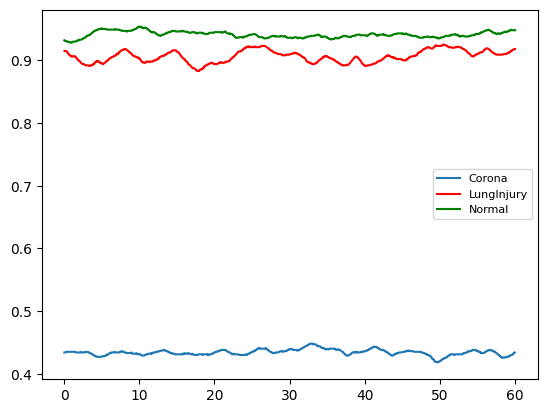

In [25]:
#Сравнение изменения координат 3-х разных людей от времени, что дает информацию, что данные сами по себе ничего не дают
plt.plot(otherDataCorona['Time'], otherDataCorona['X1'],label='Corona')
plt.plot(otherDataLung['Time'], otherDataLung['X1'], color='red',label='LungInjury')
plt.plot(otherDataNormal['Time'], otherDataNormal['X1'], color='green',label='Normal')
plt.legend(prop={'size': 8})

In [26]:
#Функция создает таблицу с вычесленными векторами и их изменением
def makeVectorTableOther(dfdata):
    n = 10 #Для скользящего среднего
    leng1 = np.sqrt(dfdata['X1']**2 + dfdata['Y1']**2 + dfdata['Z1']**2)
    leng2 = np.sqrt(dfdata['X2']**2 + dfdata['Y2']**2 + dfdata['Z2']**2)
    leng3 = np.sqrt(dfdata['X3']**2 + dfdata['Y3']**2 + dfdata['Z3']**2)
    vecData = pd.DataFrame({'Time': dfdata['Time'],
                           'RawVectorLen1': np.sqrt((dfdata['X1'].rolling(window=n).mean())**2 + (dfdata['Y1'].rolling(window=n).mean())**2 + (dfdata['Z1'].rolling(window=n).mean())**2),
                           'RawVectorLen2': np.sqrt((dfdata['X2'].rolling(window=n).mean())**2 + (dfdata['Y2'].rolling(window=n).mean())**2 + (dfdata['Z2'].rolling(window=n).mean())**2),
                           'RawVectorLen3': np.sqrt((dfdata['X3'].rolling(window=n).mean())**2 + (dfdata['Y3'].rolling(window=n).mean())**2 + (dfdata['Z3'].rolling(window=n).mean())**2),
                           'Vector3To1': np.sqrt(leng3**2 + leng1**2 - 2 * leng3 * leng1 * cossin(dfdata)),
                           'Vector3To2': np.sqrt(leng3**2 + leng2**2 - 2 * leng3 * leng2 * cossin(dfdata)),
                           'Vector1To2': np.sqrt(leng1**2 + leng2**2 - 2 * leng2 * leng1 * cossin(dfdata))})
    coordDeltaTemp = pd.DataFrame({})
    for sid in ['1', '2', '3']:
        coordDeltaTemp['X' + sid] = dfdata['X' + sid].diff()
        coordDeltaTemp['Y' + sid] = dfdata['Y' + sid].diff()
        coordDeltaTemp['Z' + sid] = dfdata['Z' + sid].diff()
    for sid in ['1', '2', '3']:
        vecData['VectorLenDelta' + sid] = np.sqrt(coordDeltaTemp['X' + sid]**2 + coordDeltaTemp['Y' + sid]**2 + coordDeltaTemp['Z' + sid]**2)

    # Временные координаты
    coordDeltaTemp = pd.DataFrame({})
    for crd in ['X', 'Y', 'Z']:
        # X, Y и Z второй точки относительно первой
        coordDeltaTemp[crd + '3to1'] = dfdata[crd + '1'] - dfdata[crd + '3']
        coordDeltaTemp[crd + '3to2'] = dfdata[crd + '2'] - dfdata[crd + '3']
        coordDeltaTemp[crd + '1to2'] = dfdata[crd + '2'] - dfdata[crd + '1']

        # Изменения X, Y и Z между точками
        coordDeltaTemp[crd + '3to1delta'] = coordDeltaTemp[crd + '3to1'].diff()
        coordDeltaTemp[crd + '3to2delta'] = coordDeltaTemp[crd + '3to2'].diff()
        coordDeltaTemp[crd + '1to2delta'] = coordDeltaTemp[crd + '1to2'].diff()

    # Длины векторов сдвига точек
    vecData['VectorLenDelta3To1'] = np.sqrt(coordDeltaTemp['X3to1delta']**2 + coordDeltaTemp['Y3to1delta']**2 + coordDeltaTemp['Z3to1delta']**2)
    vecData['VectorLenDelta3To2'] = np.sqrt(coordDeltaTemp['X3to2delta']**2 + coordDeltaTemp['Y3to2delta']**2 + coordDeltaTemp['Z3to2delta']**2)
    vecData['VectorLenDelta1To2'] = np.sqrt(coordDeltaTemp['X1to2delta']**2 + coordDeltaTemp['Y1to2delta']**2 + coordDeltaTemp['Z1to2delta']**2)

    vecData['TimeDelta'] = vecData['Time'].diff()
    vecData['Speed1']=vecData['RawVectorLen1']/vecData['TimeDelta']
    vecData['Speed2']=vecData['RawVectorLen2']/vecData['TimeDelta']
    vecData['Speed3']=vecData['RawVectorLen3']/vecData['TimeDelta']
    vecData['SpeedDelta1']=vecData['Speed1'].diff()
    vecData['SpeedDelta2']=vecData['Speed2'].diff()
    vecData['SpeedDelta3']=vecData['Speed3'].diff()
                            
    return vecData

#Создает таблицу с знаением коссинусов 
def cossin(dfdata):
    return (dfdata['X1']*dfdata['X2'] + dfdata['Y1']*dfdata['Y2'] + dfdata['Z1']*dfdata['Z2'])/(
        (dfdata['X1']**2 + dfdata['Y1']**2 + dfdata['Z1']**2)**0.5 * (dfdata['X2']**2 + dfdata['Y2']**2 + dfdata['Z2']**2)**0.5)

In [27]:
#Функция создает таблицу, где указаны вздохи человека
def makeFrequencyTable(data, sid='1'):
    result = pd.DataFrame()
    i=1
    maxVector=0
    season=sm.tsa.seasonal_decompose(data['RawVectorLen'+sid].dropna(), model='additive', period=100).seasonal
    vecdata=data.dropna()
    season=season.rolling(window=10).mean()
    while i < season.shape[0]:
        if (season.iloc[i] > season.iloc[i-1]):
            maxVector=season.iloc[i]
        if (abs(season.iloc[i]) < maxVector): 
            result=result.append({'InspirAmplit':vecdata['RawVectorLen'+sid].iloc[i], 'Time':vecdata['Time'].iloc[i]},ignore_index=True)
            maxVector=0
        i+=1
            
    return result

vectorDataCor1 = makeVectorTableOther(otherDataCorona)
temp=makeFrequencyTable(vectorDataCor1)
temp

C:\Users\User\AppData\Local\Temp\ipykernel_3352\2304732748.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append({'InspirAmplit':vecdata['RawVectorLen'+sid].iloc[i], 'Time':vecdata['Time'].iloc[i]},ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_3352\2304732748.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append({'InspirAmplit':vecdata['RawVectorLen'+sid].iloc[i], 'Time':vecdata['Time'].iloc[i]},ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_3352\2304732748.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append({'InspirAmplit':vecdata['RawVectorLen'+sid].iloc[i], 'Time':vecdata['Time'].iloc[i]},ignore_index=True)
C:\Users\User\AppData\

,InspirAmplit,Time
0,4.406676,1.618679
1,4.401775,3.961723
2,4.403782,8.280170
3,4.397021,10.624630
4,4.398091,14.953030
5,4.404382,17.285970
6,4.412674,21.629120
7,4.406984,23.964180
8,4.403112,28.274770
9,4.416035,30.616680


In [29]:
#Создает таблицу со вздохами всех людей
def allFreqencyTable(data):
    result=pd.DataFrame({'IsCorona':{},'Type of breath':{},'Frequency':{},'Mean Amplitude':{},'Sex':{}})
    typesBr=['брюшное','грудное','обычное','смешанное']
    j=0
    for i in range(1,87):
        for typBr in typesBr:
            str="Репозиторий дыхания/"+f'{i:04}'+"_"+typBr+".tsv"
            dfData=makeVectorTableOther(load_measurements(str)).dropna()
            if (dfData.shape[0]>=200):
                freqdf=makeFrequencyTable(dfData)
                res=data['isCoronavirus'].loc[data['humanID']==i].iloc[1]
                if (res=='No'):
                    result.loc[j] = [0,typBr,freqdf.shape[0],freqdf['InspirAmplit'].mean(),data['sex'].loc[data['humanID']==i].iloc[1]]
                else:
                    result.loc[j] = [1,typBr,freqdf.shape[0],freqdf['InspirAmplit'].mean(),data['sex'].loc[data['humanID']==i].iloc[1]]
            j+=1
    return result

tmp=allFreqencyTable(data)
tmp

C:\Users\User\AppData\Local\Temp\ipykernel_3352\1459508221.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tempData.iloc[:,i] = pd.to_numeric(tempData.iloc[:,i].str.replace(',', '.'))
C:\Users\User\AppData\Local\Temp\ipykernel_3352\2304732748.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append({'InspirAmplit':vecdata['RawVectorLen'+sid].iloc[i], 'Time':vecdata['Time'].iloc[i]},ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_3352\2304732748.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=result.append({'InspirAmplit':vecdata['RawVectorLen'+sid

,IsCorona,Type of breath,Frequency,Mean Amplitude,Sex
0,0,брюшное,44,4.698119,M
1,0,грудное,18,4.679109,M
2,0,обычное,27,4.666866,M
3,0,смешанное,18,4.700822,M
4,0,брюшное,17,4.567769,M
...,...,...,...,...,...
339,0,смешанное,18,4.661691,F
340,0,брюшное,17,4.264564,M
341,0,грудное,26,4.324331,M
342,0,обычное,17,4.292789,M


C:\Users\User\AppData\Local\Temp\ipykernel_872\3101447811.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp[tmp['Type of breath']=='смешанное']['Frequency'],color='BLUE',hist=False,label='смешанное')
C:\Users\User\AppData\Local\Temp\ipykernel_872\3101447811.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed29

Text(0.5, 1.0, 'Распределение частот(вдох/мин) всех людей')

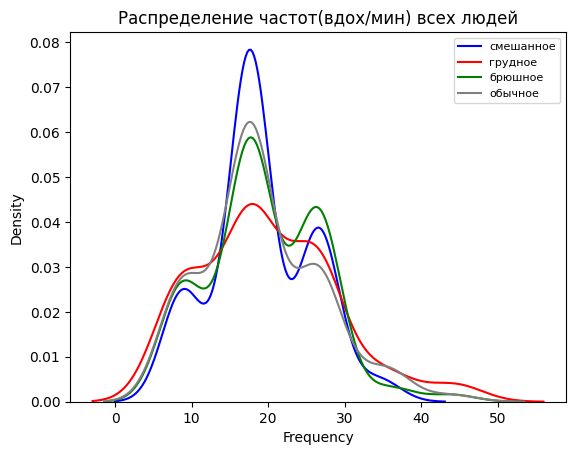

In [109]:
sns.distplot(tmp[tmp['Type of breath']=='смешанное']['Frequency'],color='BLUE',hist=False,label='смешанное')
sns.distplot(tmp[tmp['Type of breath']=='грудное']['Frequency'],color='RED',hist=False,label='грудное')
sns.distplot(tmp[tmp['Type of breath']=='брюшное']['Frequency'],color='GREEN',hist=False,label='брюшное')
sns.distplot(tmp[tmp['Type of breath']=='обычное']['Frequency'],color='GREY',hist=False,label='обычное')
plt.legend(prop={'size': 8})
plt.title('Распределение частот(вдох/мин) всех людей')

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   humanID               360 non-null    int64 
 1   date                  360 non-null    object
 2   sex                   360 non-null    object
 3   isCoronavirus         360 non-null    object
 4   startDateCoronavirus  360 non-null    object
 5   endDateCoronavirus    360 non-null    object
 6   isLungInjury          360 non-null    object
 7   percent               360 non-null    int64 
 8   type                  360 non-null    object
dtypes: int64(2), object(7)
memory usage: 25.4+ KB


In [84]:
vectorDataCorona1 = makeVectorTableOther(otherDataCorona)
vectorDataHealthy1 = makeVectorTableOther(otherDataNormal)
vectorDataCorona1

,Time,RawVectorLen1,RawVectorLen2,RawVectorLen3,Vector3To1,Vector3To2,Vector1To2,VectorLenDelta1,VectorLenDelta2,VectorLenDelta3,VectorLenDelta3To1,VectorLenDelta3To2,VectorLenDelta1To2,TimeDelta,Speed1,Speed2,Speed3,SpeedDelta1,SpeedDelta2,SpeedDelta3
0,0.032280,NaN,NaN,NaN,0.205826,0.254370,0.258138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.100163,NaN,NaN,NaN,0.206255,0.256129,0.259193,0.000000,0.001414,0.001414,1.414214e-03,0.002449,0.001414,0.067883,NaN,NaN,NaN,NaN,NaN,NaN
2,0.143463,NaN,NaN,NaN,0.206511,0.256337,0.260117,0.001414,0.000000,0.000000,1.414214e-03,0.000000,0.001414,0.043300,NaN,NaN,NaN,NaN,NaN,NaN
3,0.232391,NaN,NaN,NaN,0.207306,0.256628,0.261649,0.002236,0.001414,0.000000,2.236068e-03,0.001414,0.002236,0.088928,NaN,NaN,NaN,NaN,NaN,NaN
4,0.287331,NaN,NaN,NaN,0.207340,0.255583,0.259950,0.003162,0.000000,0.002000,1.414214e-03,0.002000,0.003162,0.054940,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,59.700400,4.404721,4.553222,4.412801,0.201353,0.242051,0.252692,0.001732,0.001000,0.002449,1.000000e-03,0.003317,0.002449,0.088210,49.934481,51.617984,50.026085,-39.443386,-40.764990,-39.471098
896,59.759280,4.404425,4.552888,4.414323,0.200900,0.241779,0.251297,0.002236,0.000000,0.000000,2.236068e-03,0.000000,0.002236,0.058880,74.803410,77.324865,74.971516,24.868929,25.706880,24.945430
897,59.811080,4.404538,4.552719,4.415900,0.200562,0.241585,0.250380,0.002449,0.001414,0.001414,1.414214e-03,0.000000,0.001414,0.051800,85.029691,87.890322,85.249041,10.226280,10.565457,10.277525
898,59.897070,4.404619,4.552642,4.417562,0.200859,0.241324,0.250058,0.001000,0.000000,0.001000,8.881784e-16,0.001000,0.001000,0.085990,51.222456,52.943857,51.372970,-33.807234,-34.946465,-33.876071


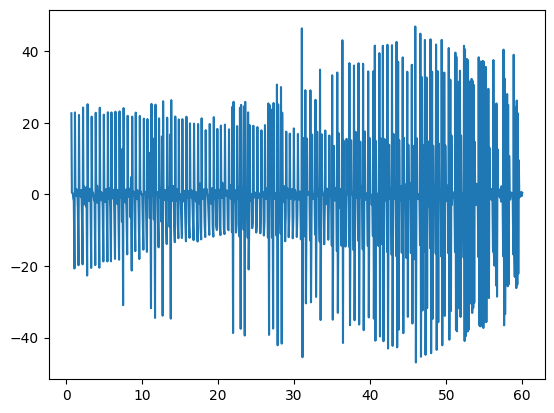

In [85]:
#Изменение скорости человека во времени(а нужен ли?)
plt.plot(vectorDataHealthy1['Time'], vectorDataHealthy1['SpeedDelta1'])

In [86]:
SpeedFromCoronaAbdominal = pd.DataFrame({'IsCorona' : {},
                                            'MaxPoint1Offset' : {}, 'MaxPoint2Offset' : {}, 'MaxPoint3Offset' : {},
                                            'AvgPoint1Offset' : {}, 'AvgPoint2Offset' : {}, 'AvgPoint3Offset' : {},
                                            'Avg3To1' : {}, 'Avg3To2' : {}, 'Avg1To2' : {},
                                            'Avg3To1Speed' : {}, 'Avg3To2Speed' : {}, 'Avg1To2Speed' : {}})
for i in range(1, 87):
    str = "Репозиторий дыхания/" + f'{i:04}' + "_брюшное.tsv"
    df = makeVectorTableOther(load_measurements(str)).dropna()
    df['TimeDelta'].replace(to_replace = 0, value = df['TimeDelta'].mean(), inplace = True)
    res = data['isCoronavirus'].loc[data['humanID'] == i].iloc[1]
    if (res == 'No'):
        SpeedFromCoronaAbdominal.loc[i - 1] = [0,
                                                abs(((df['RawVectorLen1'])).dropna()).max(),
                                                abs(((df['RawVectorLen2'])).dropna()).max(),
                                                abs(((df['RawVectorLen3'])).dropna()).max(),
                                                abs(((df['RawVectorLen1'])).dropna()).mean(),
                                                abs(((df['RawVectorLen2'])).dropna()).mean(),
                                                abs(((df['RawVectorLen3'])).dropna()).mean(),
                                                abs(((df['Vector3To1'])).dropna()).mean(),
                                                abs(((df['Vector3To2'])).dropna()).mean(),
                                                abs(((df['Vector1To2'])).dropna()).mean(),
                                                abs(((df['VectorLenDelta3To1'] / df['TimeDelta'])).dropna()).mean(),
                                                abs(((df['VectorLenDelta3To2'] / df['TimeDelta'])).dropna()).mean(),
                                                abs(((df['VectorLenDelta1To2'] / df['TimeDelta'])).dropna()).mean()]
    else:
        SpeedFromCoronaAbdominal.loc[i - 1] = [1,
                                                abs(((df['RawVectorLen1'])).dropna()).max(),
                                                abs(((df['RawVectorLen2'])).dropna()).max(),
                                                abs(((df['RawVectorLen3'])).dropna()).max(),
                                                abs(((df['RawVectorLen1'])).dropna()).mean(),
                                                abs(((df['RawVectorLen2'])).dropna()).mean(),
                                                abs(((df['RawVectorLen3'])).dropna()).mean(),
                                                abs(((df['Vector3To1'])).dropna()).mean(),
                                                abs(((df['Vector3To2'])).dropna()).mean(),
                                                abs(((df['Vector1To2'])).dropna()).mean(),
                                                abs(((df['VectorLenDelta3To1'] / df['TimeDelta'])).dropna()).mean(),
                                                abs(((df['VectorLenDelta3To2'] / df['TimeDelta'])).dropna()).mean(),
                                                abs(((df['VectorLenDelta1To2'] / df['TimeDelta'])).dropna()).mean()]

SpeedFromCoronaAbdominal

C:\Users\User\AppData\Local\Temp\ipykernel_872\1459508221.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tempData.iloc[:,i] = pd.to_numeric(tempData.iloc[:,i].str.replace(',', '.'))
C:\Users\User\AppData\Local\Temp\ipykernel_872\1459508221.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tempData.iloc[:,i] = pd.to_numeric(tempData.iloc[:,i].str.replace(',', '.'))
C:\Users\User\AppData\Local\Temp\ipykernel_872\1459508221.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always

,IsCorona,MaxPoint1Offset,MaxPoint2Offset,MaxPoint3Offset,AvgPoint1Offset,AvgPoint2Offset,AvgPoint3Offset,Avg3To1,Avg3To2,Avg1To2,Avg3To1Speed,Avg3To2Speed,Avg1To2Speed
0,0.0,4.712517,4.879012,4.718585,4.697578,4.867352,4.697558,0.192902,0.259483,0.259410,0.040074,0.036135,0.036220
1,0.0,4.612370,4.796238,4.626927,4.566213,4.760866,4.572334,0.153324,0.244916,0.249592,0.038481,0.037081,0.029388
2,0.0,4.513286,4.634486,4.517737,4.466635,4.623327,4.499690,0.202847,0.237238,0.255761,0.050448,0.032673,0.053347
3,1.0,4.417230,4.563878,4.427295,4.404632,4.554432,4.412199,0.204085,0.251380,0.255598,0.028989,0.024768,0.027055
4,0.0,4.659481,4.765745,4.668433,4.641945,4.759294,4.655571,0.209007,0.235079,0.241251,0.028349,0.022486,0.030104
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,4.212105,4.161528,4.341015,4.195572,4.143957,4.319864,0.282817,0.307776,0.254180,0.024428,0.022994,0.026225
82,0.0,4.197533,4.146602,4.292902,4.182863,4.127889,4.283258,0.300332,0.321263,0.283368,0.021595,0.026095,0.025652
83,1.0,4.255549,4.167272,4.357996,4.240518,4.155082,4.345487,0.279746,0.319570,0.267638,0.024148,0.027400,0.026022
84,0.0,4.664409,4.586603,4.762290,4.654105,4.566758,4.747477,0.281321,0.319039,0.274499,0.021983,0.022617,0.020383


In [87]:
print('Зависимость болезни от амплитуды точки 1',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['MaxPoint1Offset']))
print('Зависимость болезни от амплитуды точки 2',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['MaxPoint2Offset']))
print('Зависимость болезни от амплитуды точки 3',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['MaxPoint3Offset']))
print('Зависимость болезни от среднего отклонения точки 1',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['AvgPoint1Offset']))
print('Зависимость болезни от среднего отклонения точки 2',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['AvgPoint2Offset']))
print('Зависимость болезни от среднего отклонения точки 3',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['AvgPoint3Offset']))
print('Зависимость болезни от среднего отклонения точки 1 от точки 3',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['Avg3To1']))
print('Зависимость болезни от среднего отклонения точки 2 от точки 3',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['Avg3To2']))
print('Зависимость болезни от среднего отклонения точки 2 от точки 1',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['Avg1To2']))
print('Зависимость болезни от средней скорости точки 1 относительно точки 3',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['Avg3To1Speed']))
print('Зависимость болезни от средней скорости точки 2 относительно точки 3',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['Avg3To2Speed']))
print('Зависимость болезни от средней скорости точки 2 относительно точки 1',stats.kruskal(SpeedFromCoronaAbdominal['IsCorona'], SpeedFromCoronaAbdominal['Avg1To2Speed']))

Зависимость болезни от амплитуды точки 1 KruskalResult(statistic=132.41745152084783, pvalue=1.2124481910120326e-30)
Зависимость болезни от амплитуды точки 2 KruskalResult(statistic=132.41745152084783, pvalue=1.2124481910120326e-30)
Зависимость болезни от амплитуды точки 3 KruskalResult(statistic=132.41745152084783, pvalue=1.2124481910120326e-30)
Зависимость болезни от среднего отклонения точки 1 KruskalResult(statistic=132.41745152084783, pvalue=1.2124481910120326e-30)
Зависимость болезни от среднего отклонения точки 2 KruskalResult(statistic=132.41745152084783, pvalue=1.2124481910120326e-30)
Зависимость болезни от среднего отклонения точки 3 KruskalResult(statistic=132.41745152084783, pvalue=1.2124481910120326e-30)
Зависимость болезни от среднего отклонения точки 1 от точки 3 KruskalResult(statistic=0.2864628480710375, pvalue=0.5924961880488353)
Зависимость болезни от среднего отклонения точки 2 от точки 3 KruskalResult(statistic=0.2864628480710375, pvalue=0.5924961880488353)
Зависимо

In [88]:
# Разделяем данные на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(SpeedFromCoronaAbdominal['MaxPoint1Offset'].values, SpeedFromCoronaAbdominal['IsCorona'], test_size=0.3)

In [89]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train.reshape(-1, 1), y_train)

y_pred = dtc.predict(X_test.reshape(-1, 1))
dtc.score(X_test.reshape(-1, 1), y_test)

0.5769230769230769

In [90]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train.reshape(-1, 1), y_train)

y_pred = rfc.predict(X_test.reshape(-1, 1))
rfc.score(X_test.reshape(-1, 1), y_test)

0.5769230769230769

In [91]:
knc = KNeighborsClassifier()
knc.fit(X_train.reshape(-1, 1), y_train)

y_pred = knc.predict(X_test.reshape(-1, 1))
knc.score(X_test.reshape(-1, 1), y_test)

0.8076923076923077

In [92]:
mlp = MLPClassifier().fit(X_train.reshape(-1, 1), y_train)

y_pred = mlp.predict(X_test.reshape(-1, 1))
mlp.score(X_test.reshape(-1, 1), y_test)

0.6153846153846154

In [2]:
#Функция, анализирует данные вреальном времени и предсказывает 
def realTimeForecasting(modelForecast,nameFile, generallyData, delay=10, generalTime=60):
    i=0
    while i <= generalTime:
        sleep(delay)
        df = makeVectorTableOther(load_measurements(nameFile)).dropna()
        df['TimeDelta'].replace(to_replace = 0, value = df['TimeDelta'].mean(), inplace = True)
        res = generallyData['isCoronavirus'].loc[generallyData['humanID'] == i].iloc[1]
        if (res == 'No'):
            SpeedFromCoronaAbdominal.loc[i - 1] = [0,
                                                    abs(((df['RawVectorLen1'])).dropna()).max(),
                                                    abs(((df['RawVectorLen2'])).dropna()).max(),
                                                    abs(((df['RawVectorLen3'])).dropna()).max(),
                                                    abs(((df['RawVectorLen1'])).dropna()).mean(),
                                                    abs(((df['RawVectorLen2'])).dropna()).mean(),
                                                    abs(((df['RawVectorLen3'])).dropna()).mean(),
                                                    abs(((df['Vector3To1'])).dropna()).mean(),
                                                    abs(((df['Vector3To2'])).dropna()).mean(),
                                                    abs(((df['Vector1To2'])).dropna()).mean(),
                                                    abs(((df['VectorLenDelta3To1'] / df['TimeDelta'])).dropna()).mean(),
                                                    abs(((df['VectorLenDelta3To2'] / df['TimeDelta'])).dropna()).mean(),
                                                    abs(((df['VectorLenDelta1To2'] / df['TimeDelta'])).dropna()).mean()]
        else:
            SpeedFromCoronaAbdominal.loc[i - 1] = [1,
                                                    abs(((df['RawVectorLen1'])).dropna()).max(),
                                                    abs(((df['RawVectorLen2'])).dropna()).max(),
                                                    abs(((df['RawVectorLen3'])).dropna()).max(),
                                                    abs(((df['RawVectorLen1'])).dropna()).mean(),
                                                    abs(((df['RawVectorLen2'])).dropna()).mean(),
                                                    abs(((df['RawVectorLen3'])).dropna()).mean(),
                                                    abs(((df['Vector3To1'])).dropna()).mean(),
                                                    abs(((df['Vector3To2'])).dropna()).mean(),
                                                    abs(((df['Vector1To2'])).dropna()).mean(),
                                                    abs(((df['VectorLenDelta3To1'] / df['TimeDelta'])).dropna()).mean(),
                                                    abs(((df['VectorLenDelta3To2'] / df['TimeDelta'])).dropna()).mean(),
                                                    abs(((df['VectorLenDelta1To2'] / df['TimeDelta'])).dropna()).mean()]
        
        X_train, X_test, y_train, y_test = train_test_split(SpeedFromCoronaAbdominal['MaxPoint1Offset'].values, SpeedFromCoronaAbdominal['IsCorona'], test_size=0.3)
        modelForecast.fit(X_train.reshape(-1, 1), y_train)
        y_pred = modelForecast.predict(X_test.reshape(-1, 1))
        
        i+=delay
    
    return(modelForecast.score(X_test.reshape(-1, 1), y_test))